In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, auc, roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
import joblib


# Data Exploration

In [7]:
df=pd.read_csv("logistics_shipments_dataset.csv")
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3


In [8]:
df.describe()

,Weight_kg,Cost,Distance_miles,Transit_Days
count,2000.000000,1959.000000,2000.000000,2000.000000
mean,30.184800,205.161598,1275.868000,4.182500
std,124.967053,222.586082,691.382829,1.837902
min,0.000000,17.890000,101.000000,1.000000
25%,12.300000,117.710000,690.250000,3.000000
50%,20.700000,196.420000,1262.500000,4.000000
75%,33.925000,272.115000,1867.250000,5.000000
max,5404.200000,6562.210000,2499.000000,12.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Shipment_ID       2000 non-null   object 
 1   Origin_Warehouse  2000 non-null   object 
 2   Destination       2000 non-null   object 
 3   Carrier           2000 non-null   object 
 4   Shipment_Date     2000 non-null   object 
 5   Delivery_Date     1968 non-null   object 
 6   Weight_kg         2000 non-null   float64
 7   Cost              1959 non-null   float64
 8   Status            2000 non-null   object 
 9   Distance_miles    2000 non-null   int64  
 10  Transit_Days      2000 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 172.0+ KB


In [10]:
null_ratio=df.isnull().sum()/100
nunique=df.nunique()
exploration=pd.DataFrame({
    "null_ratio":null_ratio,
    "nunique":nunique,
    "d_type":df.dtypes
})
print(exploration)

                  null_ratio  nunique   d_type
Shipment_ID             0.00     2000   object
Origin_Warehouse        0.00       10   object
Destination             0.00       15   object
Carrier                 0.00        7   object
Shipment_Date           0.00      364   object
Delivery_Date           0.32      368   object
Weight_kg               0.00      614  float64
Cost                    0.41     1903  float64
Status                  0.00        5   object
Distance_miles          0.00     1309    int64
Transit_Days            0.00       12    int64


# Data Cleaning & Preprocessing

In [11]:
df.drop("Shipment_ID",inplace=True,axis=1)

# Handling date columns

In [12]:
#convert date columns
date_columns=[col for col in df.columns if "Date" in col]
for col in date_columns:
  df[col]=pd.to_datetime(df[col])
df['Cost']=df['Cost'].fillna(df['Cost'].mean())
df['Delivery_Date']=df['Delivery_Date'].fillna(df['Delivery_Date'].mode()[0])
df['shipment day']=df['Shipment_Date'].dt.day
df['shipment month']=df['Shipment_Date'].dt.month
df['shipment year']=df['Shipment_Date'].dt.year
df['delivery day']=df['Delivery_Date'].dt.day
df['delivery month']=df['Delivery_Date'].dt.month
df['delivery year']=df['Delivery_Date'].dt.year
df.drop(columns=['Shipment_Date','Delivery_Date'],inplace=True)

# EDA (Exploratory Data Analysis)

In [13]:
numeric_columns=df.select_dtypes(include=['int64','float64']).columns
categorical_columns=df.select_dtypes(include='object').columns

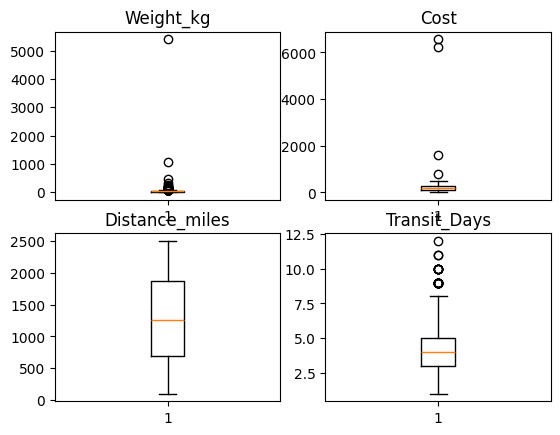

In [14]:
#detecting outliers
n_columns=2
n_rows=(len(numeric_columns)+n_columns-1)//2
for i , col in enumerate(numeric_columns):
  plt.subplot(n_rows,n_columns,i+1)
  plt.boxplot(df[col])
  plt.title(col)

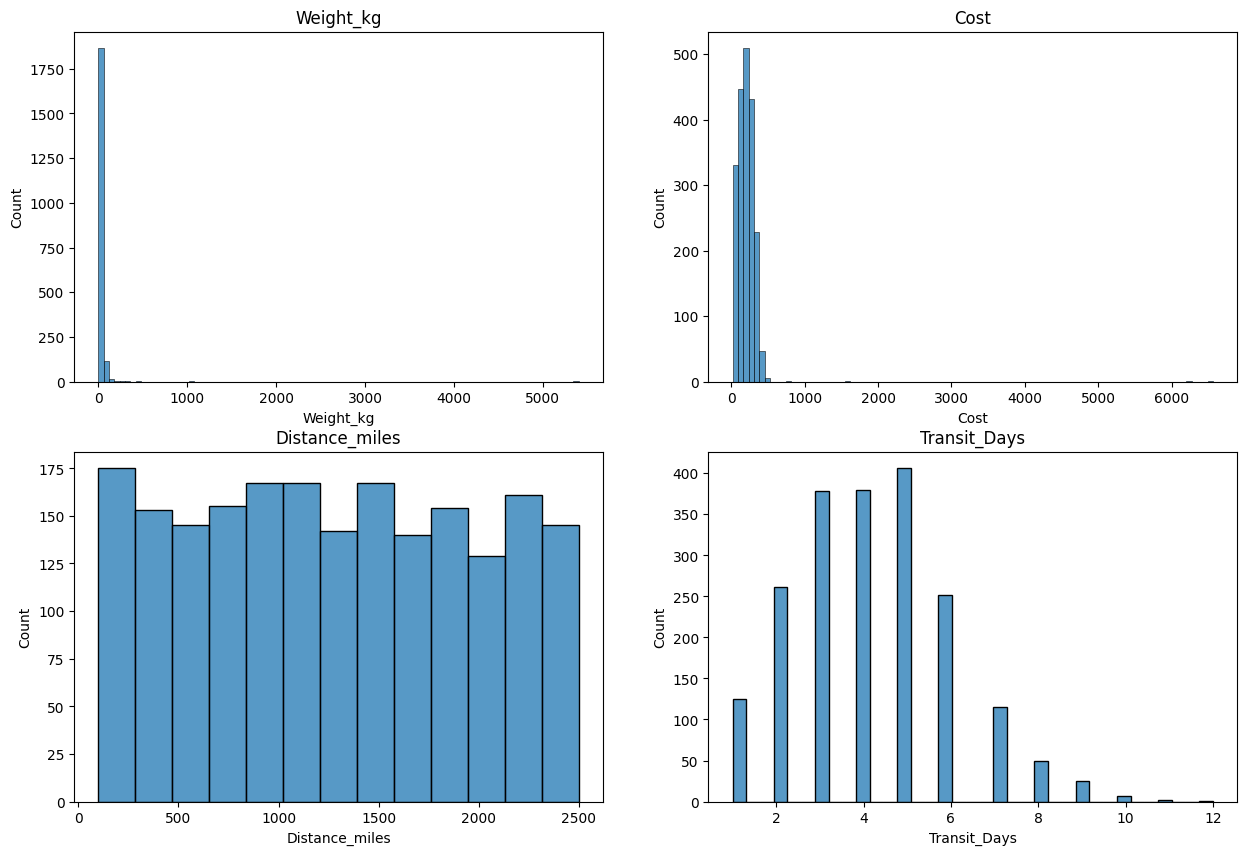

In [15]:
plt.figure(figsize=(15,10))
n_columns=2
n_rows=(len(numeric_columns)+n_columns-1)//2
for i , col in enumerate(numeric_columns):
  plt.subplot(n_rows,n_columns,i+1)
  sns.histplot(df[col])
  plt.title(col)

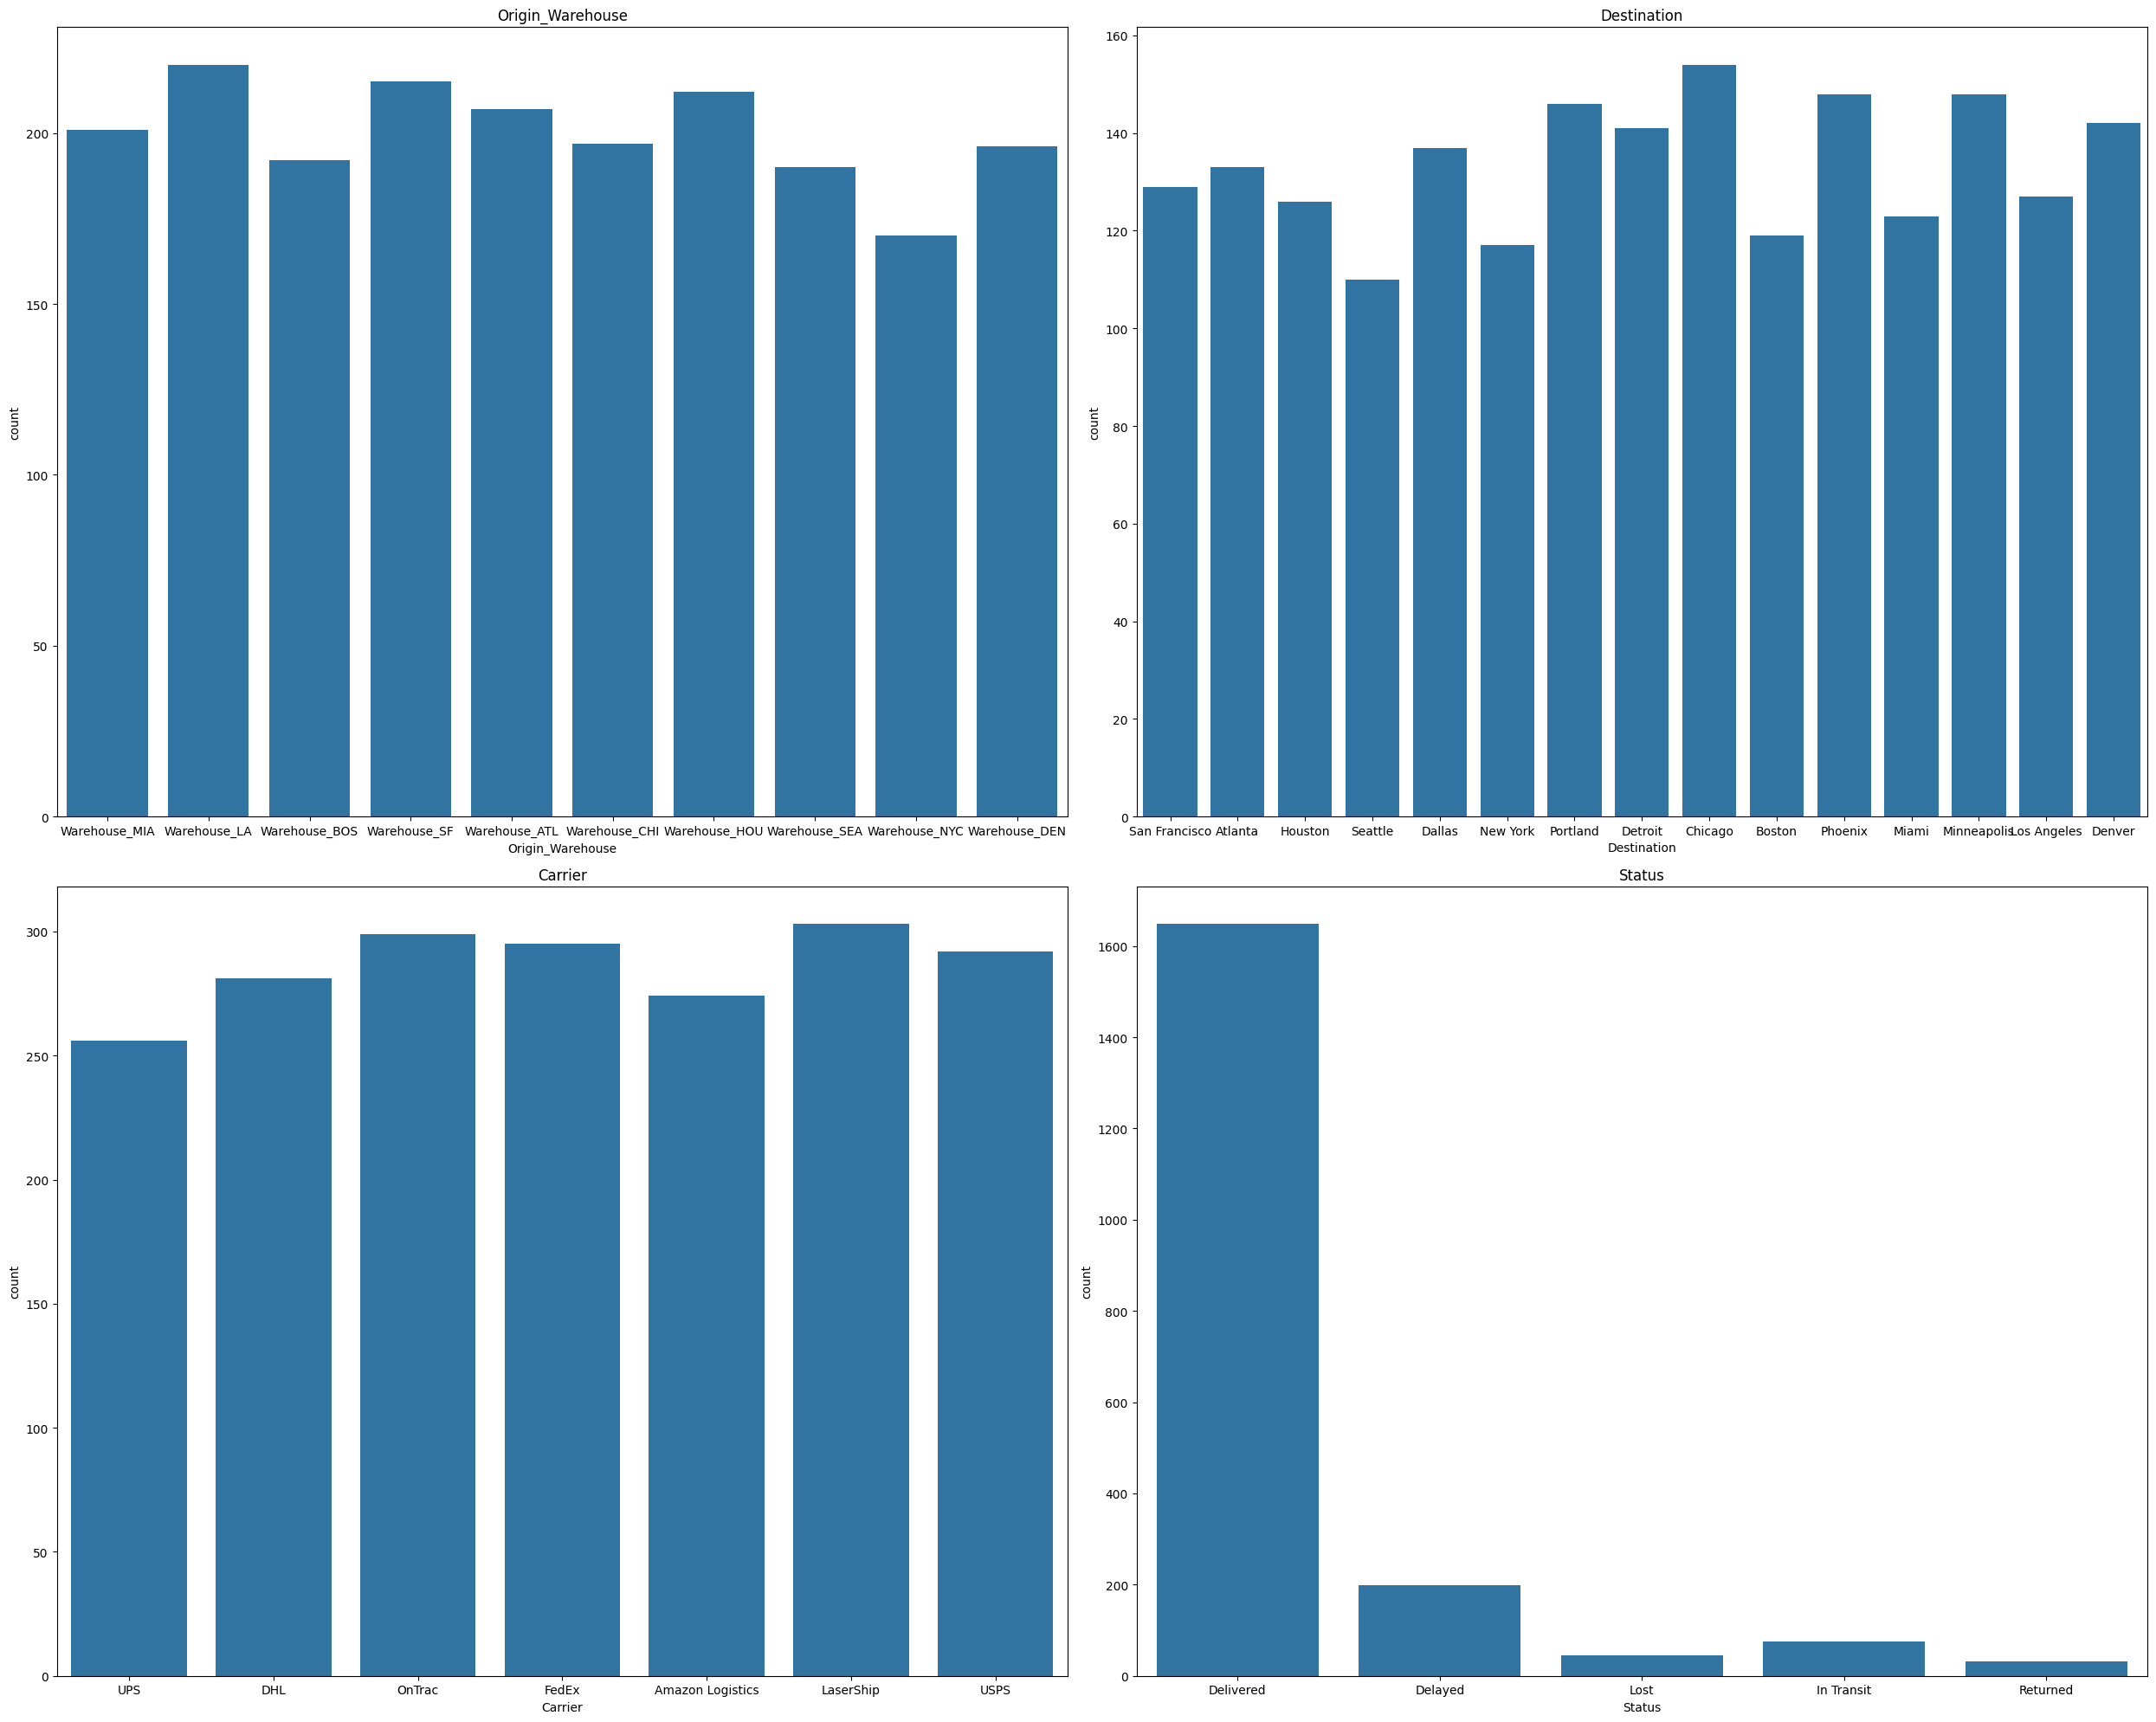

In [16]:
plt.figure(figsize=(25,20))
n_columns=2
n_rows=(len(categorical_columns)+n_columns-1)//2
for i , col in enumerate(categorical_columns):
  plt.subplot(n_rows,n_columns,i+1)
  sns.countplot(x=df[col])
  plt.title(col)
  plt.tight_layout()
  plt.ticklabel_format()

<Axes: >

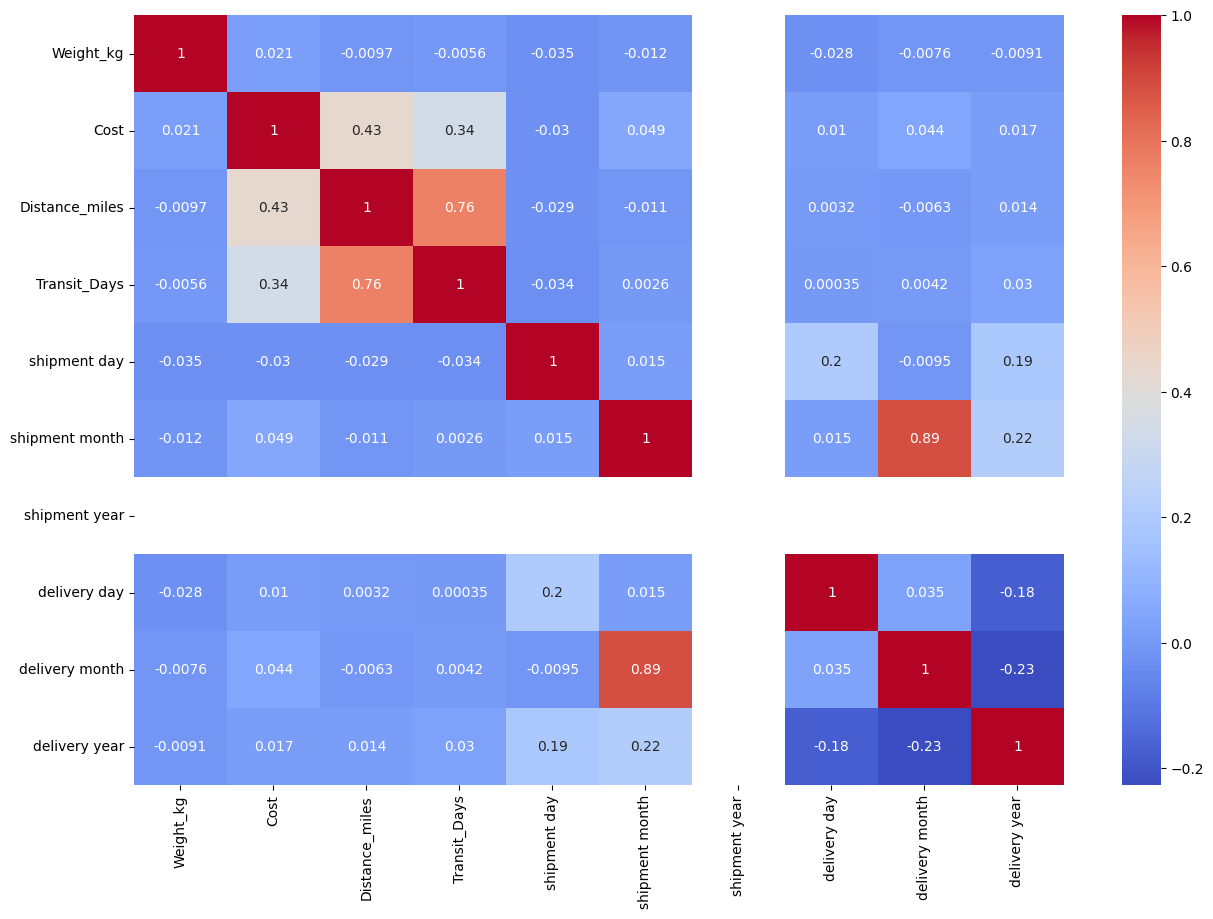

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='coolwarm')

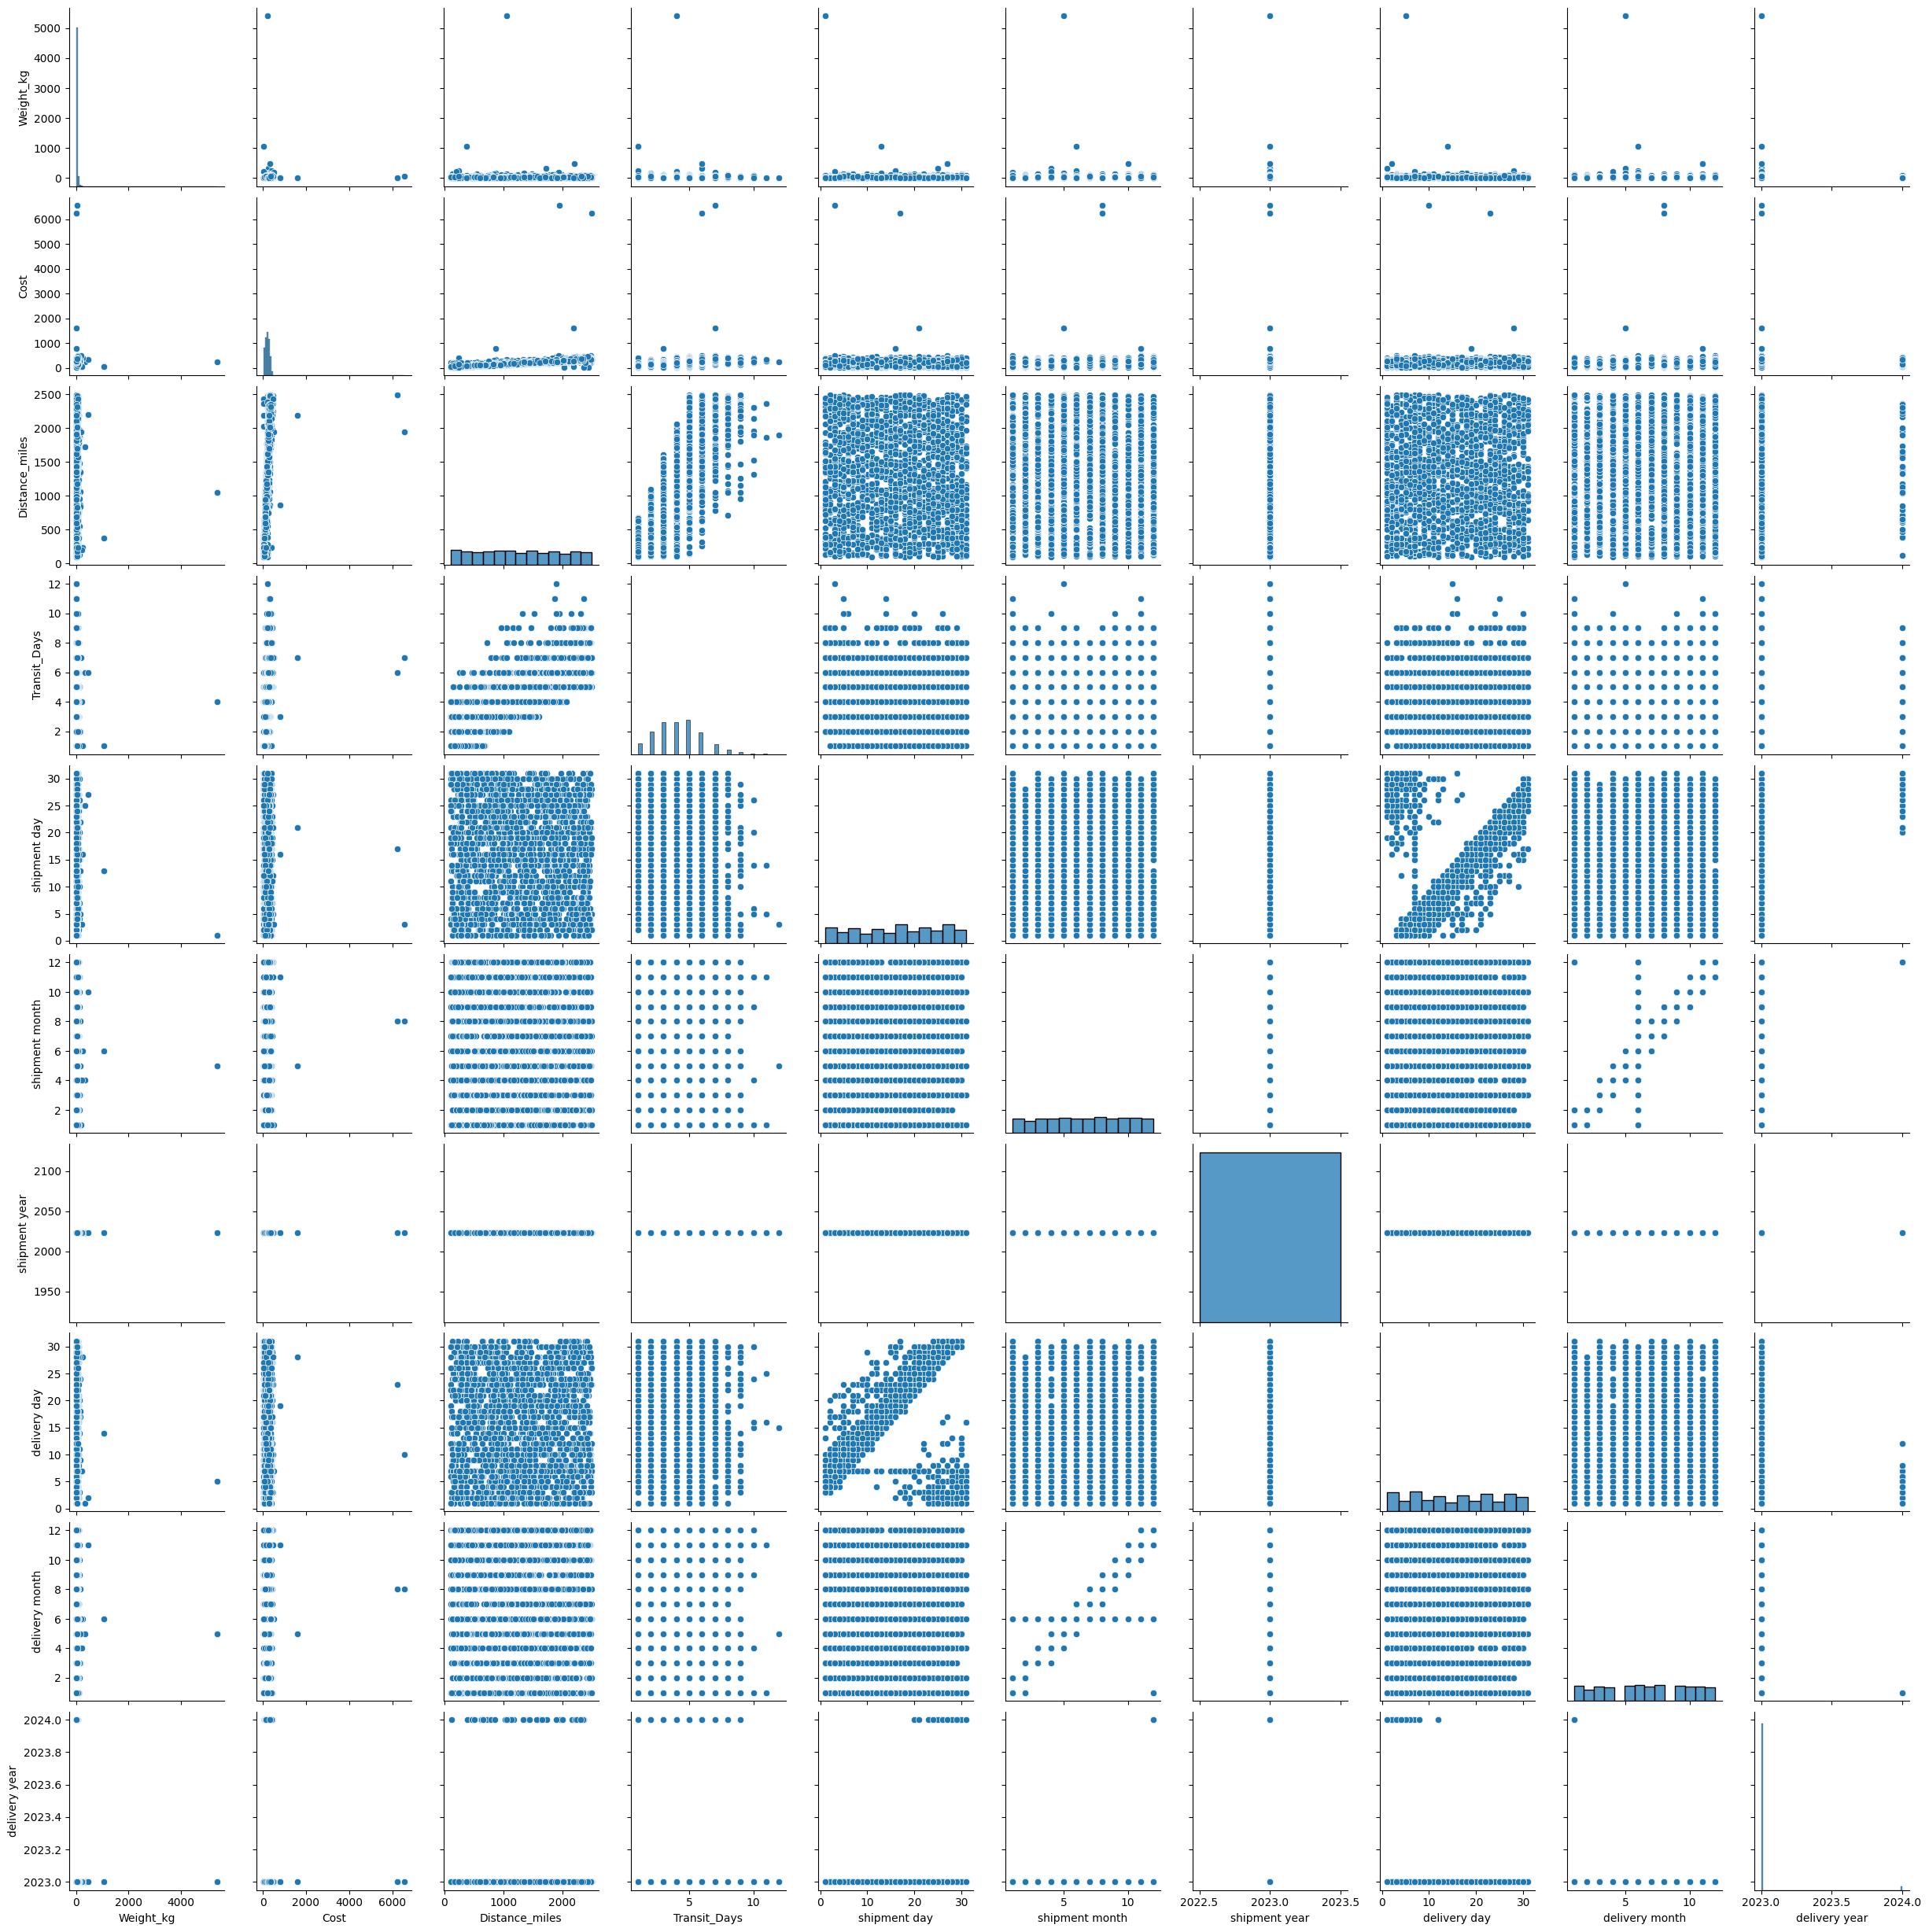

In [18]:
sns.pairplot(data=df)

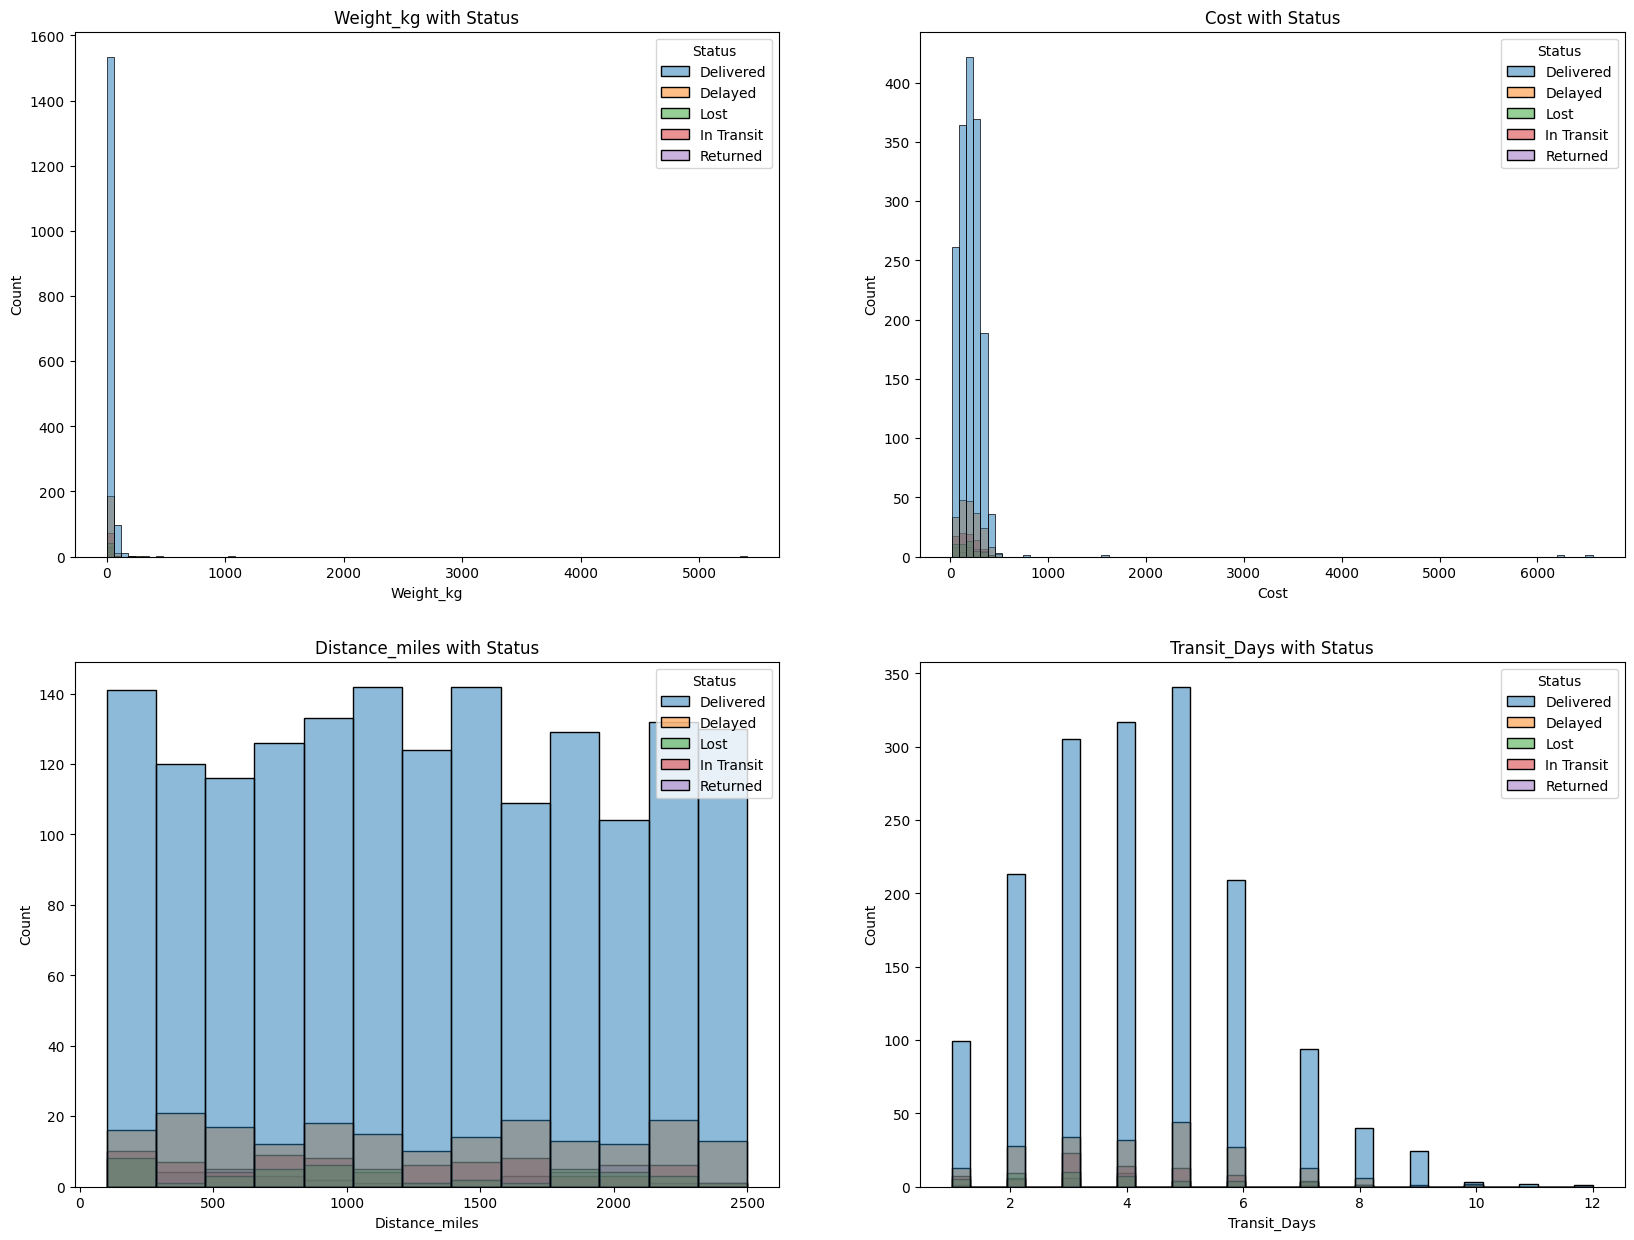

In [19]:
target='Status'
plt.figure(figsize=(20,15))
n_columns=2
n_rows=(len(numeric_columns)+n_columns-1)//2
for i , col in enumerate(numeric_columns):
  plt.subplot(n_rows,n_columns,i+1)
  sns.histplot(x=col,hue=target,data=df)
  plt.title(f"{col} with {target}")

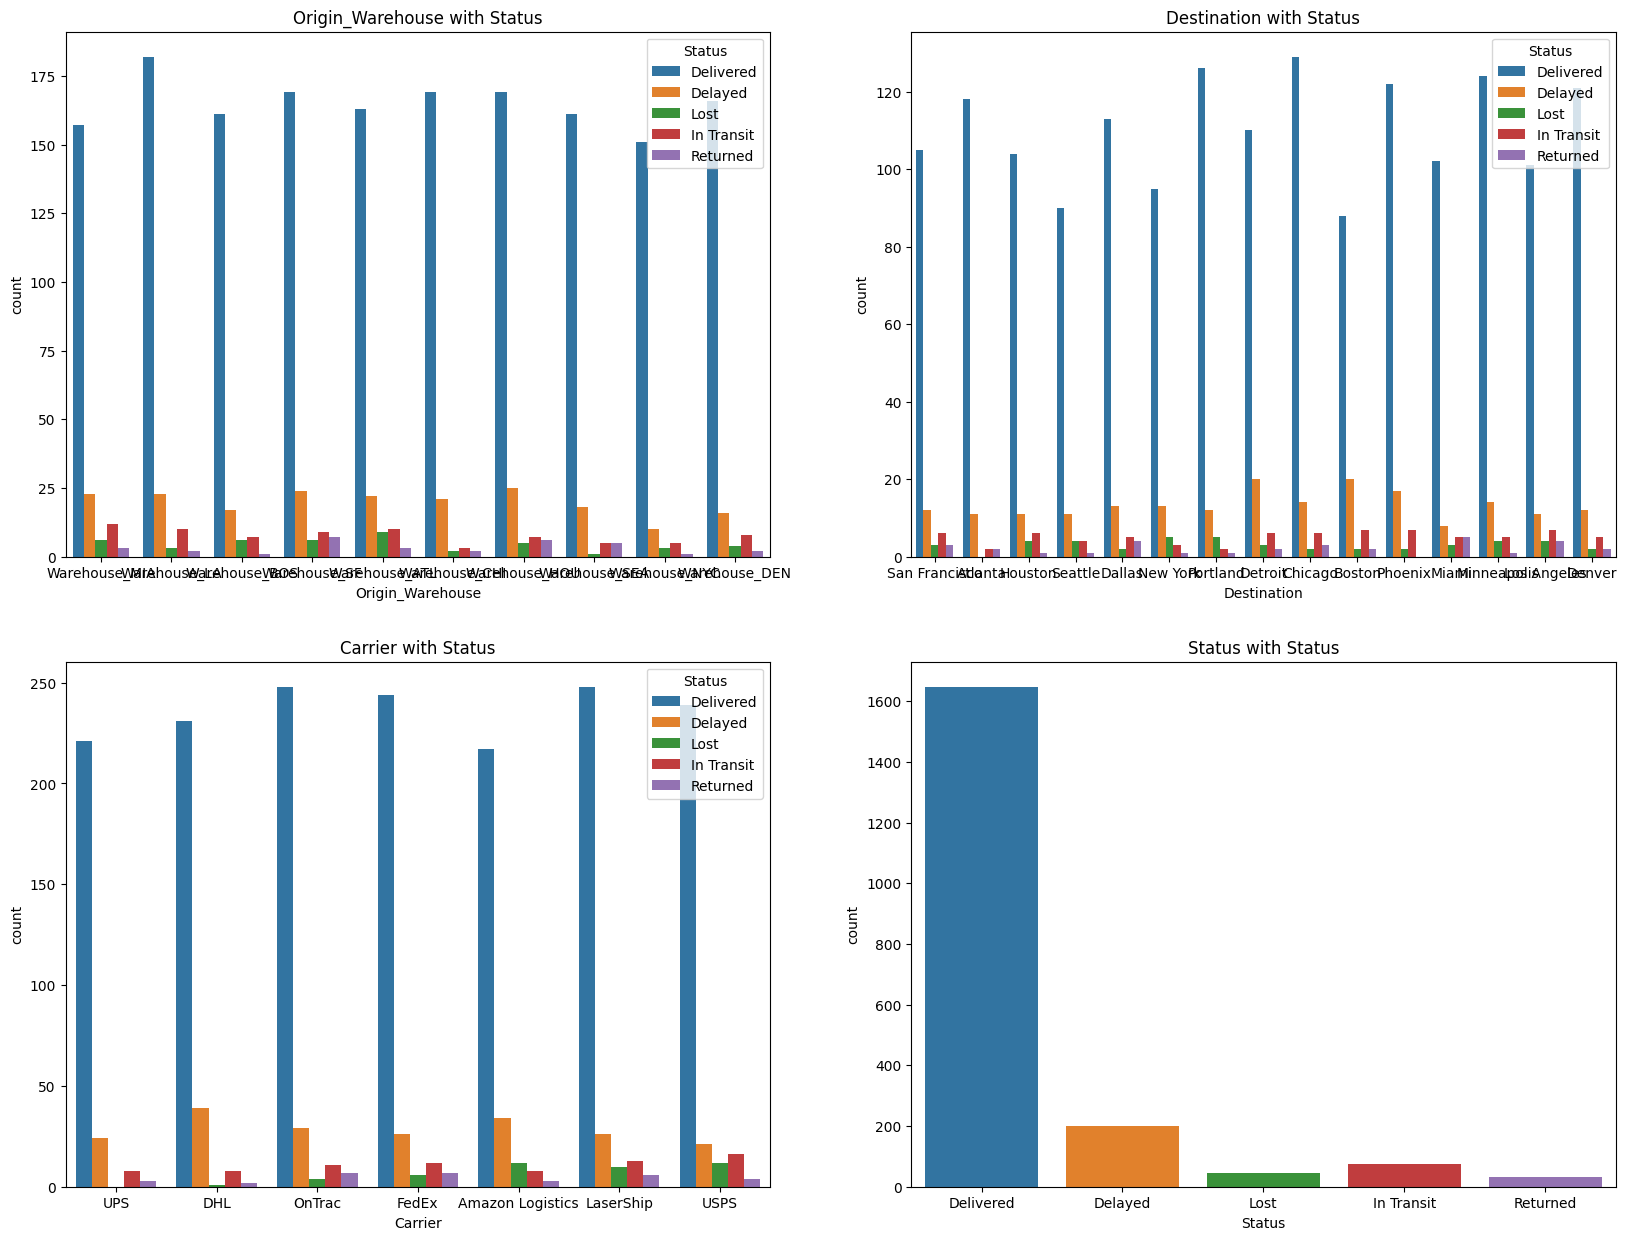

In [20]:
plt.figure(figsize=(20,15))
n_columns=2
n_rows=(len(categorical_columns)+n_columns-1)//2
for i , col in enumerate(categorical_columns):
  plt.subplot(n_rows,n_columns,i+1)
  sns.countplot(x=col,hue=target,data=df)
  plt.title(f"{col} with {target}")

In [21]:
df['Status'].value_counts()

Status
Delivered     1648
Delayed        199
In Transit      76
Lost            45
Returned        32
Name: count, dtype: int64

# NHandling Target Columns

In [22]:
def handling_status(status):
  if status=="Delivered":
    return "Delivered"
  elif status=="Delayed":
    return "Proplemtic"
  elif status=="In Transit":
    return "Proplemtic"
  elif status=="Lost":
    return "Proplemtic"
  else:
    return "Proplemtic"
df['Status']=df['Status'].apply(handling_status)

# Encoding

In [23]:
#encoding
df2=df.copy()
le=LabelEncoder()
ohe=OneHotEncoder()
for col in categorical_columns:
  if df2[col].nunique()==2:
    df2[col]=le.fit_transform(df2[col])
  else:
    df2 = pd.get_dummies(data=df2, columns=[col], drop_first=False)


# Handling Outliers

In [24]:
#handling outliers
outlier_columns=['Weight_kg','Cost','Transit_Days']
for col in outlier_columns:
  df2[col]=df2[col].apply(np.log1p)


# Spliting and Scaling

In [25]:
#drop_columns=[col for col in df.columns if 'Status' in col]
scaler=StandardScaler()
x=df2.drop(columns='Status')
y=df2['Status']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
selector=SelectKBest(chi2,k=15)    #k=5 is the best (better than pca) in
x_train=selector.fit_transform(x_train,y_train)
x_test=selector.transform(x_test)
#y_train=np.argmax(y_train,axis=1)
#y_test=np.argmax(y_test,axis=1)
# smot=SMOTE(random_state=42)
# x_train,y_train=smot.fit_resample(x_train,y_train)
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
# pca=PCA(n_components=8)
# x_train=pca.fit_transform(x_train)
# x_test=pca.transform(x_test)

# Model Definition

In [26]:
single_models = {
    "LogisticRegression": (LogisticRegression(max_iter=1000, random_state=42), {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs", "saga"],
        "class_weight": [None, "balanced"]
    }),
    "DecisionTree": (DecisionTreeClassifier(random_state=42), {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": [None, "balanced"]
    }),
    "RandomForest": (RandomForestClassifier(random_state=42), {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "class_weight": [None, "balanced"]
    }),
}

# Ensemble models (boosting)
ensemble_models = {
    "AdaBoost": (AdaBoostClassifier(random_state=42), {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    }),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 5]
    }),
    "XGBoost": (XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=42), {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7],
        "scale_pos_weight": [1, 2, 5]
    }),
}

# ----------------------------
# 3. GridSearch for each model
# ----------------------------
def run_gridsearch(models_dict, X_train, y_train, X_test, y_test):
    results = {}
    best_models = {}
    for name, (model, params) in models_dict.items():
        print(f"\n🔍 Running GridSearch for {name} ...")
        grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # ✅ fixed

        results[name] = {
            "Best Params": grid.best_params_,
            "Accuracy": acc,
            "Classification Report": report
        }
        best_models[name] = best_model
    return results, best_models






# Run models

In [27]:
print("\n=== Single Models ===")
single_results, single_best_models = run_gridsearch(single_models, x_train, y_train, x_test, y_test)

print("\n=== Ensemble Models ===")
ensemble_results, ensemble_best_models = run_gridsearch(ensemble_models, x_train, y_train, x_test, y_test)



=== Single Models ===

🔍 Running GridSearch for LogisticRegression ...

🔍 Running GridSearch for DecisionTree ...

🔍 Running GridSearch for RandomForest ...

=== Ensemble Models ===

🔍 Running GridSearch for AdaBoost ...

🔍 Running GridSearch for GradientBoosting ...

🔍 Running GridSearch for XGBoost ...


c:\Users\esraa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Show Results

In [28]:
print("\nSingle Models Results:")
for model, res in single_results.items():
    print(model, "-> Accuracy:", res["Accuracy"])
    print("Best Params:", res["Best Params"])
    print("Classification Report:\n",
          classification_report(y_test, single_best_models[model].predict(x_test), zero_division=0))  # ✅ fixed


print("\nEnsemble Models Results:")
for model, res in ensemble_results.items():
    print(model, "-> Accuracy:", res["Accuracy"])
    print("Best Params:", res["Best Params"])
    print("Classification Report:\n",
          classification_report(y_test, ensemble_best_models[model].predict(x_test), zero_division=0))  # ✅ fixed


# Example: access a best model directly
best_logreg = single_best_models["LogisticRegression"]
print("\nStored Logistic Regression Model:", best_logreg)



Single Models Results:
LogisticRegression -> Accuracy: 0.8283333333333334
Best Params: {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91       497
           1       0.00      0.00      0.00       103

    accuracy                           0.83       600
   macro avg       0.41      0.50      0.45       600
weighted avg       0.69      0.83      0.75       600

DecisionTree -> Accuracy: 0.8383333333333334
Best Params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       497
           1       1.00      0.06      0.11       103

    accuracy                           0.84       600
   macro avg       0.92      0.53      0.51       600
weighted avg       0.86   

c:\Users\esraa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:34:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.8516666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       497
           1       0.73      0.21      0.33       103

    accuracy                           0.85       600
   macro avg       0.80      0.60      0.62       600
weighted avg       0.84      0.85      0.82       600



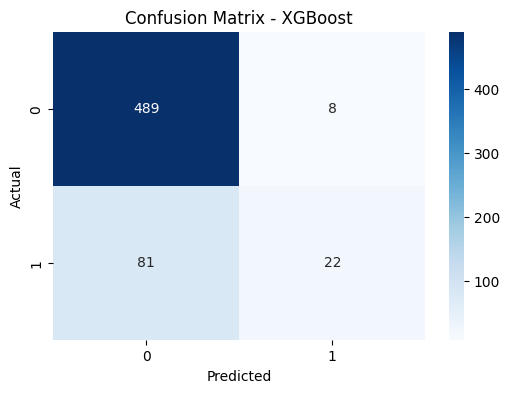

<Figure size 1000x600 with 0 Axes>

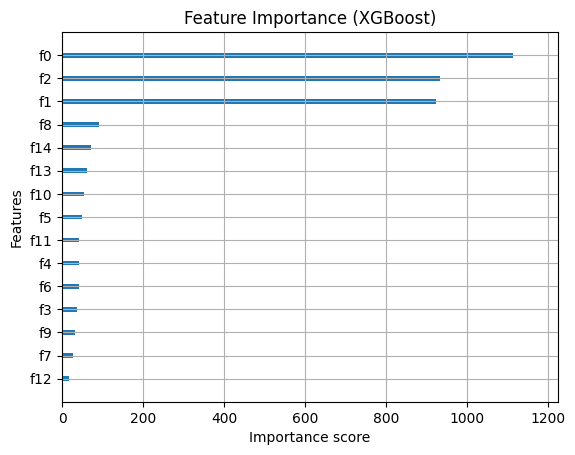

['xgb_model.pkl']

In [29]:

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=1,   
    eval_metric="mlogloss",
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

plt.figure(figsize=(10,6))
plot_importance(xgb_model, importance_type="weight", show_values=False)
plt.title("Feature Importance (XGBoost)")
plt.show()
joblib.dump(xgb_model, 'xgb_model.pkl')


# Using XGBoosting as the best model

In [31]:
df.columns

Index(['Origin_Warehouse', 'Destination', 'Carrier', 'Weight_kg', 'Cost',
       'Status', 'Distance_miles', 'Transit_Days', 'shipment day',
       'shipment month', 'shipment year', 'delivery day', 'delivery month',
       'delivery year'],
      dtype='object')

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
for col in categorical_columns:
  if df[col].nunique()==2:
    df[col]=le.fit_transform(df[col])
num_features = df.select_dtypes(include=['int64','float64']).columns
cat_features = df.select_dtypes(include=['object','category']).columns
x=df.drop(columns='Status')
y=df['Status']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)
# selector=SelectKBest(chi2,k=15)
# x_train=selector.fit_transform(x_train,y_train)
# x_test=selector.transform(x_test)
num_transformer=Pipeline(steps=[
   ("log", FunctionTransformer(np.log1p,validate=False)),
    ("scaler", StandardScaler())
])
cat_transformer=OneHotEncoder(handle_unknown="ignore")
preprocessor=ColumnTransformer(
    transformers=[
        ("num",num_transformer,num_features),
        ("cat",cat_transformer,cat_features)
    ])
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        scale_pos_weight=1,
        eval_metric="mlogloss",
        random_state=42
    ))
])
xgb_pipeline.fit(x_train, y_train)
y_pred = xgb_pipeline.predict(x_test)

# ----------------------------
# 4. Evaluation
# ----------------------------
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


ValueError: A given column is not a column of the dataframe